# Setup

In [1]:
import tensorflow as tf

from pathlib import Path
from matplotlib import pyplot as plt

# Load data

In [2]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64


def load_data(dataset, subset):
    path = Path("datasets") / dataset / subset
    return tf.keras.utils.image_dataset_from_directory(
        path,
        image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=BATCH_SIZE,
        class_names=["blank", "1", "2", "3", "4", "5", "6", "7", "8", "9", "candidates"])


def get_photo_ds(subset):
    return load_data("digit_classification", subset).map(lambda images, labels: (images / 255.0, labels))

In [3]:
def random_translation(images):
    shift = tf.random.uniform((2,), minval=-8, maxval=8, dtype=tf.int32)
    return tf.roll(images, shift, axis=(-3, -2))


def data_augmentation(images):
    images = random_translation(images)
    return images

In [4]:
train_ds = (
    get_photo_ds("train")
    .cache()
    .shuffle(1000)
    .map(lambda images, labels: (data_augmentation(images), labels))
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    get_photo_ds("val")
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    get_photo_ds("test")
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

Found 6480 files belonging to 11 classes.
Found 6480 files belonging to 11 classes.
Found 6480 files belonging to 11 classes.


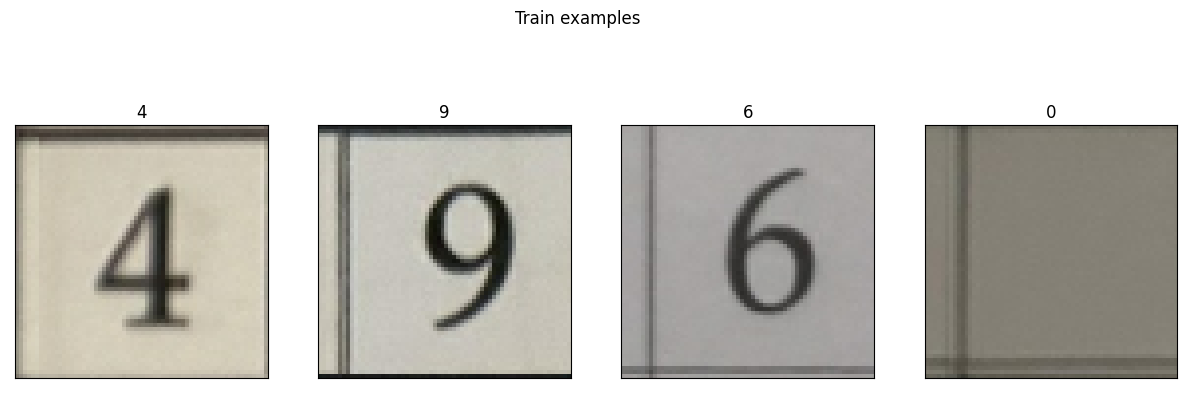

In [5]:
# Show some training examples

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle("Train examples")

for ax, (image, label) in zip(axs.flat, train_ds.unbatch()):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(label.numpy())
    ax.imshow(image)

plt.show()

# Train model

In [6]:
# Model inspired by SimpleNet and https://github.com/luckymouse0/SimpleNet-TF/blob/master/sn.py

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.SpatialDropout2D(0.2),

    tf.keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.SpatialDropout2D(0.2),

    tf.keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.SpatialDropout2D(0.2),

    tf.keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.SpatialDropout2D(0.2),

    tf.keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.SpatialDropout2D(0.2),

    tf.keras.layers.Conv2D(11, kernel_size=3, padding="same"),

    tf.keras.layers.GlobalAvgPool2D()
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 64, 64, 128)       0

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True), "accuracy"]
)

In [8]:
class SaveBatchMetrics(tf.keras.callbacks.Callback):
    def __init__(self, *args, **kwargs):
        super(SaveBatchMetrics, self).__init__(*args, **kwargs)
        self.loss = []
        self.val_loss = []
        self.accuracy = []
        self.val_accuracy = []

    def on_epoch_begin(self, epoch, logs=None):
        for metric in [self.loss, self.val_loss, self.accuracy, self.val_accuracy]:
            metric.append([])

    def on_train_batch_end(self, batch, logs=None):
        self.loss[-1].append(logs["loss"])
        self.accuracy[-1].append(logs["accuracy"])
    
    def on_test_batch_end(self, batch, logs=None):
        self.val_loss[-1].append(logs["loss"])
        self.val_accuracy[-1].append(logs["accuracy"])
    
    def on_epoch_end(self, epoch, logs=None):
        for metric in [self.loss, self.val_loss, self.accuracy, self.val_accuracy]:
            values = metric[-1]
            # Iterate values backwards so we don't use the overwritten values as inputs and propagate errors
            for i in range(len(values) - 1, 0, -1):
                values[i] = (((i + 1) / i) * values[i] - values[i - 1]) * i
    
    def get_metrics(self):
        return {
            "loss": self._flatten(self.loss),
            "val_loss": self._flatten(self.val_loss),
            "accuracy": self._flatten(self.accuracy),
            "val_accuracy": self._flatten(self.val_accuracy)
        }
    
    def _flatten(self, metric):
        return [x for xs in metric for x in xs]


In [9]:
# Start training

EPOCHS = 20

current_epoch = 0

batch_metrics_callback = SaveBatchMetrics()

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    initial_epoch=current_epoch,
    callbacks=[batch_metrics_callback]
)

current_epoch += EPOCHS

batch_metrics = batch_metrics_callback.get_metrics()

Epoch 1/20


203/203 [==============================] - 17s 69ms/step - loss: 1.7208 - sparse_categorical_crossentropy: 1.7208 - accuracy: 0.4994 - val_loss: 2.3800 - val_sparse_categorical_crossentropy: 2.3800 - val_accuracy: 0.2335
Epoch 2/20
203/203 [==============================] - 13s 64ms/step - loss: 1.1786 - sparse_categorical_crossentropy: 1.1786 - accuracy: 0.6340 - val_loss: 2.5102 - val_sparse_categorical_crossentropy: 2.5102 - val_accuracy: 0.2613
Epoch 3/20
203/203 [==============================] - 13s 64ms/step - loss: 0.8759 - sparse_categorical_crossentropy: 0.8759 - accuracy: 0.7744 - val_loss: 1.1759 - val_sparse_categorical_crossentropy: 1.1759 - val_accuracy: 0.6785
Epoch 4/20
203/203 [==============================] - 13s 65ms/step - loss: 0.6361 - sparse_categorical_crossentropy: 0.6361 - accuracy: 0.8571 - val_loss: 0.8793 - val_sparse_categorical_crossentropy: 0.8793 - val_accuracy: 0.8037
Epoch 5/20
203/203 [==============================] - 13s 65ms/step - loss: 0.4533 

In [10]:
def show_training_plots(history, separate_train_and_val=False, epochs=None, end_epoch=None):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    if separate_train_and_val:
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        axs_loss = axs[0, :]
        axs_acc = axs[1, :]
        ax_loss_train = axs_loss[0]
        ax_loss_val = axs_loss[1]
        ax_acc_train = axs_acc[0]
        ax_acc_val = axs_acc[1]
    else:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        axs_loss = [axs[0]]
        axs_acc = [axs[1]]
        ax_loss_train = ax_loss_val = axs[0]
        ax_acc_train = ax_acc_val = axs[1]

    for ax in axs.flat:
        ax.set_xlabel("epoch")

    for ax in axs_loss:
        ax.set_title("Loss vs epoch")
        ax.set_ylabel("loss")
    
    def plot(ax, values, label, color):
        if epochs is None:
            ax.plot(values, label=label, color=color)
        else:
            ax.plot(range(end_epoch - epochs, end_epoch), values[end_epoch-epochs:end_epoch], label=label, color=color)

    plot(ax_loss_train, loss, label="train", color="C0")
    plot(ax_loss_val, val_loss, label="val", color="C1")

    for ax in axs_acc:
        ax.set_title("Accuracy vs epoch")
        ax.set_ylabel("accuracy")

    plot(ax_acc_train, acc, label="train", color="C0")
    plot(ax_acc_val, val_acc, label="val", color="C1")

    for ax in axs.flat:
        ax.legend()

    plt.show()

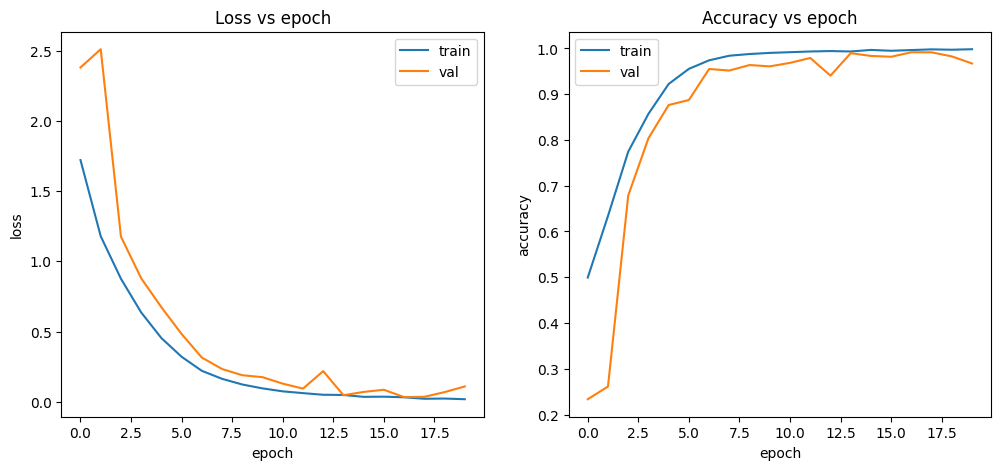

In [11]:
# Show first training plots

show_training_plots(history)

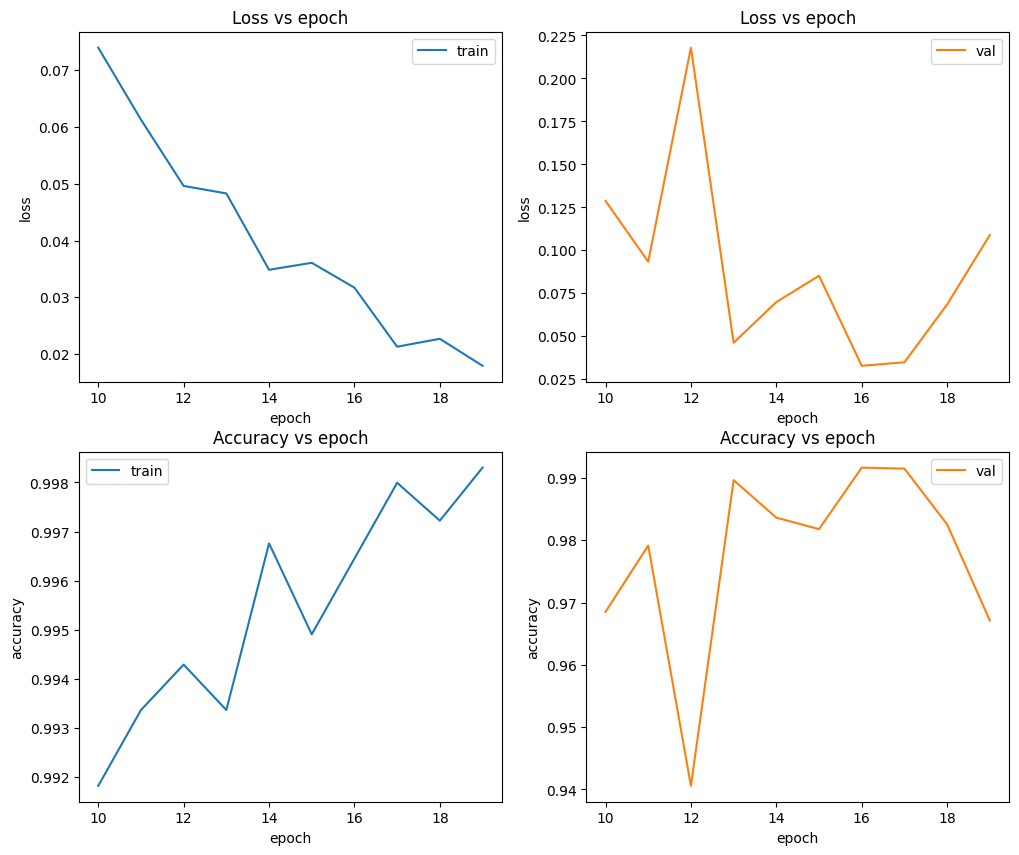

In [12]:
# Show later plots

show_training_plots(history, separate_train_and_val=True, epochs=10, end_epoch=current_epoch)

In [13]:
# Change learning rate

model.optimizer.learning_rate.assign(1e-5)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-05>

Epoch 21/30


203/203 [==============================] - 13s 64ms/step - loss: 0.0155 - sparse_categorical_crossentropy: 0.0155 - accuracy: 0.9989 - val_loss: 0.0363 - val_sparse_categorical_crossentropy: 0.0363 - val_accuracy: 0.9909
Epoch 22/30
203/203 [==============================] - 13s 64ms/step - loss: 0.0131 - sparse_categorical_crossentropy: 0.0131 - accuracy: 0.9991 - val_loss: 0.0333 - val_sparse_categorical_crossentropy: 0.0333 - val_accuracy: 0.9920
Epoch 23/30
203/203 [==============================] - 13s 64ms/step - loss: 0.0143 - sparse_categorical_crossentropy: 0.0143 - accuracy: 0.9980 - val_loss: 0.0332 - val_sparse_categorical_crossentropy: 0.0332 - val_accuracy: 0.9923
Epoch 24/30
203/203 [==============================] - 13s 64ms/step - loss: 0.0127 - sparse_categorical_crossentropy: 0.0127 - accuracy: 0.9988 - val_loss: 0.0277 - val_sparse_categorical_crossentropy: 0.0277 - val_accuracy: 0.9934
Epoch 25/30
203/203 [==============================] - 13s 64ms/step - loss: 0.0

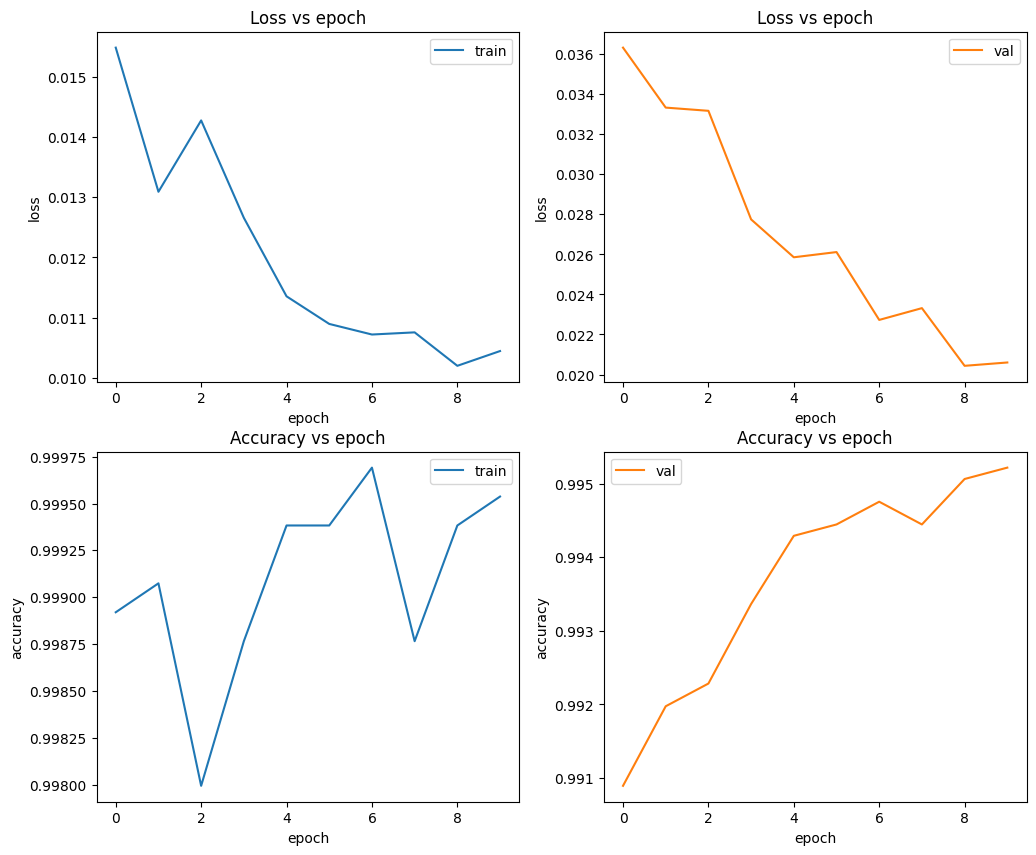

In [14]:
# More training

more_epochs = 10

history = model.fit(
    train_ds,
    epochs = current_epoch + more_epochs,
    validation_data=val_ds,
    initial_epoch=current_epoch,
)

current_epoch += more_epochs

# Show plots

show_training_plots(history, separate_train_and_val=True)

In [15]:
# Change learning rate

model.optimizer.learning_rate.assign(1e-6)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-06>

Epoch 31/40


203/203 [==============================] - 13s 64ms/step - loss: 0.0098 - sparse_categorical_crossentropy: 0.0098 - accuracy: 0.9994 - val_loss: 0.0216 - val_sparse_categorical_crossentropy: 0.0216 - val_accuracy: 0.9949
Epoch 32/40
203/203 [==============================] - 13s 64ms/step - loss: 0.0110 - sparse_categorical_crossentropy: 0.0110 - accuracy: 0.9989 - val_loss: 0.0218 - val_sparse_categorical_crossentropy: 0.0218 - val_accuracy: 0.9948
Epoch 33/40
203/203 [==============================] - 13s 64ms/step - loss: 0.0087 - sparse_categorical_crossentropy: 0.0087 - accuracy: 1.0000 - val_loss: 0.0230 - val_sparse_categorical_crossentropy: 0.0230 - val_accuracy: 0.9944
Epoch 34/40
203/203 [==============================] - 13s 64ms/step - loss: 0.0097 - sparse_categorical_crossentropy: 0.0097 - accuracy: 0.9992 - val_loss: 0.0227 - val_sparse_categorical_crossentropy: 0.0227 - val_accuracy: 0.9944
Epoch 35/40
203/203 [==============================] - 13s 64ms/step - loss: 0.0

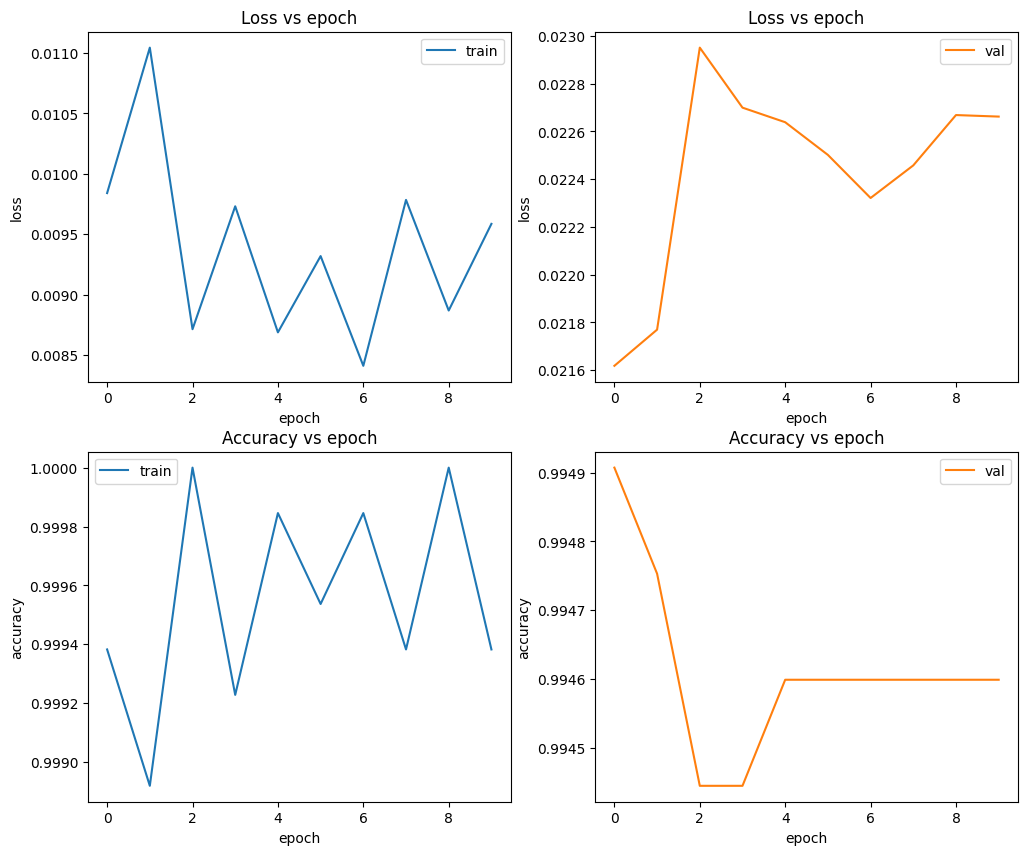

In [16]:
# More training

more_epochs = 10

history = model.fit(
    train_ds,
    epochs = current_epoch + more_epochs,
    validation_data=val_ds,
    initial_epoch=current_epoch,
)

current_epoch += more_epochs

# Show plots

show_training_plots(history, separate_train_and_val=True)

In [17]:
model.save(Path("models") / "digit_classifier" / "keras")

INFO:tensorflow:Assets written to: models\digit_classifier\keras\assets


INFO:tensorflow:Assets written to: models\digit_classifier\keras\assets


# Diagnostics

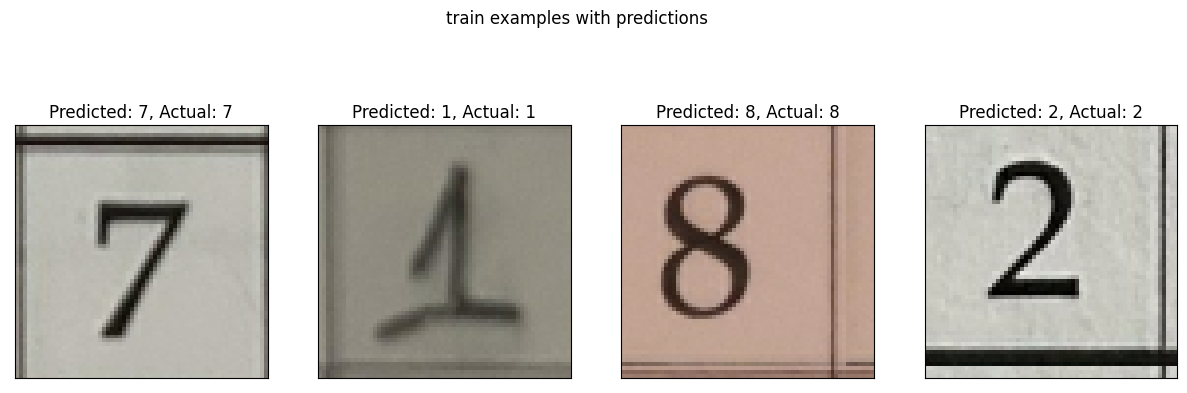

In [18]:
# Show some examples from train

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle("train examples with predictions")

for ax, (image, label) in zip(axs.flat, train_ds.unbatch().shuffle(100)):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    pred = model(tf.expand_dims(image, axis=0)).numpy().argmax()
    label = label.numpy()
    ax.set_title(f"Predicted: {pred}, Actual: {label}")
    ax.imshow(image)

plt.show()

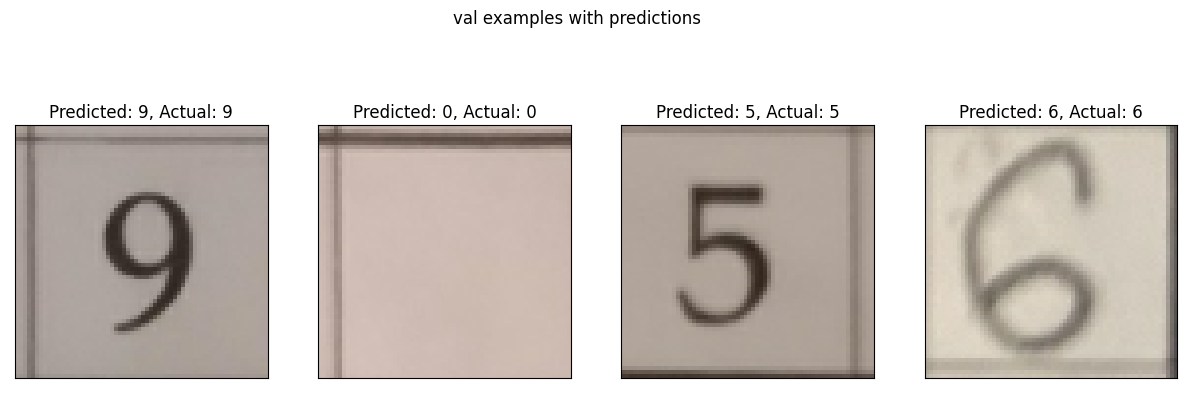

In [19]:
# Show some examples from val

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle("val examples with predictions")

for ax, (image, label) in zip(axs.flat, val_ds.unbatch().shuffle(100)):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    pred = model(tf.expand_dims(image, axis=0)).numpy().argmax()
    label = label.numpy()
    ax.set_title(f"Predicted: {pred}, Actual: {label}")
    ax.imshow(image)

plt.show()

# Evaluate on test dataset

In [20]:
model.evaluate(test_ds)

203/203 [==============================] - 4s 17ms/step - loss: 0.0084 - sparse_categorical_crossentropy: 0.0084 - accuracy: 0.9983


[0.008437848649919033, 0.008437848649919033, 0.9983024597167969]